In [451]:
# Ensure the project root is in PATH.
import sys

sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing
import matplotlib.pyplot as plt

from backtester.log import Log
import numpy as np
import pandas as pd
import sys
import os






# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

In [452]:
market_data_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_0.csv"), sep=";")
market_data_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_1.csv"), sep=";")
market_data_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "prices_round_3_day_2.csv"), sep=";")

trades_round_3_day_0 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_0.csv"), sep=";")
trades_round_3_day_1 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_1.csv"), sep=";")
trades_round_3_day_2 = pd.read_csv(os.path.join("..", "data", "round3", "trades_round_3_day_2.csv"), sep=";")


market_data_round_3_all3days = concatenate_historical_data([market_data_round_3_day_0, market_data_round_3_day_1, market_data_round_3_day_2])
trades_round_3_all3days = concatenate_historical_data([trades_round_3_day_0, trades_round_3_day_1, market_data_round_3_day_2])

In [ ]:
from datamodel import (
    TradingState,
    Trade,
    OrderDepth,
    Order,
    Observation,
    ConversionObservation,
    Listing,
)
import numpy as np
import pandas as pd
from collections import defaultdict
import heapq

CROISSANTS = "CROISSANTS"
DJEMBES = "DJEMBES"
JAMS = "JAMS"
KELP = "KELP"
PICNIC_BASKET1 = "PICNIC_BASKET1"
PICNIC_BASKET2 = "PICNIC_BASKET2"
RAINFOREST_RESIN = "RAINFOREST_RESIN"
SQUID_INK = "SQUID_INK"
VOLCANIC_ROCK = "VOLCANIC_ROCK"
VOLCANIC_ROCK_VOUCHER_10000 = "VOLCANIC_ROCK_VOUCHER_10000"
VOLCANIC_ROCK_VOUCHER_10250 = "VOLCANIC_ROCK_VOUCHER_10250"
VOLCANIC_ROCK_VOUCHER_10500 = "VOLCANIC_ROCK_VOUCHER_10500"
VOLCANIC_ROCK_VOUCHER_9500 = "VOLCANIC_ROCK_VOUCHER_9500"
VOLCANIC_ROCK_VOUCHER_9750 = "VOLCANIC_ROCK_VOUCHER_9750"
 
class Trader:
    position_limit = {
        CROISSANTS: 250,
        DJEMBES: 60,
        JAMS: 350,
        KELP: 50,
        PICNIC_BASKET1: 60,
        PICNIC_BASKET2: 100,
        RAINFOREST_RESIN: 50,
        SQUID_INK: 50,
        VOLCANIC_ROCK: 400,
        VOLCANIC_ROCK_VOUCHER_10000: 200,
        VOLCANIC_ROCK_VOUCHER_10250: 200,
        VOLCANIC_ROCK_VOUCHER_10500: 200,
        VOLCANIC_ROCK_VOUCHER_9500: 200,
        VOLCANIC_ROCK_VOUCHER_9750: 200,
    }

    def __init__(self):
        self.max_profits_over_time = []
        self.desired_position_over_time = {
            CROISSANTS: [],
            DJEMBES: [],
            JAMS: [],
            PICNIC_BASKET1: [],
            PICNIC_BASKET2: [],
            "timestamp": [],
        }
        pass

    def get_mid_price(self, order_depths: dict[str, OrderDepth], symbol: str) -> float:
        return (max(order_depths[symbol].buy_orders) + min(order_depths[symbol].sell_orders)) / 2

    def get_best_bid_best_ask(self, order_depths: dict[str, OrderDepth], symbol: str) -> tuple[int, int]:
        return max(order_depths[symbol].buy_orders), min(order_depths[symbol].sell_orders)

    def get_spread(self, order_depths: dict[str, OrderDepth], symbol: str) -> float:
        bb, ba = self.get_best_bid_best_ask(order_depths, symbol)
        return abs(ba - bb)

    
    # create orders for this
    def order_position_change(self, state: TradingState, position_change: dict[str, int]) -> dict[str, list[Order]]:
        result = {}

        for symbol, change in position_change.items():
            result[symbol] = []
            bbid, bask = self.get_best_bid_best_ask(state.order_depths, symbol)

            if change > 0:
                result[symbol] = [Order(symbol, bask, int(abs(change)))]
            elif change < 0:
                result[symbol] = [Order(symbol, bbid, int(-abs(change)))]
        return result
 

    def run(self, state: TradingState):
        result = {}

        # position_change_to_desired = self.calculate_position_change(state.position, self.desired_position)
        # if all(abs(v) <= 1 for k, v in position_change_to_desired.items()):
        #     print("At desired")
        # Then we can determine what our new position is.

        # Sizing should be relative to the edge. Just like with our previous algorithms.
        c = self.get_mid_price(state.order_depths, CROISSANTS)
        d = self.get_mid_price(state.order_depths, DJEMBES)
        j = self.get_mid_price(state.order_depths, JAMS)
        b1 = self.get_mid_price(state.order_depths, PICNIC_BASKET1)
        b2 = self.get_mid_price(state.order_depths, PICNIC_BASKET2)

        sb1 = b1 - 6 * c - 3 * j - 1 * d
        sb2 = b2 - 4 * c - 2 * j

        b1_as_b2_plus_nav = b2 + 2 * c + j + d
        b1_as_one_point_five_b2_plus_nav = 1.5 * b2 + d

        spreadk = 0
        # Spreads (all positive values)
        spr_c = spreadk * self.get_spread(state.order_depths, CROISSANTS)
        spr_d = spreadk * self.get_spread(state.order_depths, DJEMBES)
        spr_j = spreadk * self.get_spread(state.order_depths, JAMS)
        spr_b1 = spreadk * self.get_spread(state.order_depths, PICNIC_BASKET1)
        spr_b2 = spreadk * self.get_spread(state.order_depths, PICNIC_BASKET2)

        profitability = {
            "long_b1_short_nav": -(sb1 - spreadk * (spr_b1 + 6 * spr_c + 3 * spr_j + spr_d)),
            "short_b1_long_nav": sb1 - spreadk * (spr_b1 + 6 * spr_c + 3 * spr_j + spr_d),
            "long_b2_short_nav": -(sb2 - spreadk * (spr_b2 + 4 * spr_c + 2 * spr_j)),
            "short_b2_long_nav": sb2 - spreadk * (spr_b2 + 4 * spr_c + 2 * spr_j),
            "long_b1_short_b1_as_b2_plus_nav": -((b1 - b1_as_b2_plus_nav) - spreadk * (spr_b1 + spr_b2 + 2 * spr_c + spr_j)),
            "short_b1_long_b1_as_b2_plus_nav": (b1 - b1_as_b2_plus_nav) - spreadk * (spr_b1 + spr_b2 + 2 * spr_c + spr_j),
            "long_b1_short_b1_as_one_point_five_b2_plus_nav": -((b1 - b1_as_one_point_five_b2_plus_nav) - spreadk * (spr_b1 + 1.5 * spr_b2 + spr_d)),
            "short_b1_long_b1_as_one_point_five_b2_plus_nav": (b1 - b1_as_one_point_five_b2_plus_nav) - spreadk * (spr_b1 + 1.5 * spr_b2 + spr_d),
            "long_croissant": -spreadk * spr_c,
            "short_croissant": -spreadk * spr_c,
            "long_djembe": -spreadk * spr_d,
            "short_djembe": -spreadk * spr_d,
            "long_jam": -spreadk * spr_j,
            "short_jam": -spreadk * spr_j,
        }
        
        if profitability['long_b1_short_nav']

        traderData = "SAMPLE"
        conversions = 1
        return result, conversions, traderData

In [454]:
# _calculate_position_over_time calculates position over time
# Parameters: a symbol like "KELP".
# Returns: the net position, over time
def _calculate_position_over_time(symbol: str, trade_history: list, market_data: pd.DataFrame) -> list[int]:
    positions = [0]
    timestamps = [0]

    current_pos = 0

    for trade in trade_history:
        if trade.symbol != symbol:
            continue

        if trade.buyer == "SUBMISSION":
            current_pos += abs(trade.quantity)
        elif trade.seller == "SUBMISSION":
            current_pos -= abs(trade.quantity)
        else:
            continue

        positions.append(current_pos)
        timestamps.append(trade.timestamp)

    max_timestamp = market_data.iloc[len(market_data) - 1]["timestamp"]
    # Edge case so it displays constant 0 position instead of just 1 dot.
    if max_timestamp != timestamps[-1]:
        timestamps.append(max_timestamp)
        positions.append(positions[-1])

    ## TEMPORRARY

    # df = pd.DataFrame(columns=["timestamp", f"position_{symbol}"])
    # df["timestamp"] = timestamps
    # df[f"position_{symbol}"] = positions
    # df.to_csv(f"position_over_time_{symbol}.csv")

    ##TEMPORARY

    return timestamps, positions

In [455]:
# 1. Define the listings. (optimisation - only define symbols we are trading)
listings = {
    "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    # "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
    # "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    # "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK": Listing(symbol="VOLCANIC_ROCK", product="VOLCANIC_ROCK", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10000": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10000", product="VOLCANIC_ROCK_VOUCHER_10000", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10250": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10250", product="VOLCANIC_ROCK_VOUCHER_10250", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_10500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_10500", product="VOLCANIC_ROCK_VOUCHER_10500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9500": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9500", product="VOLCANIC_ROCK_VOUCHER_9500", denomination="SEASHELLS"),
    # "VOLCANIC_ROCK_VOUCHER_9750": Listing(symbol="VOLCANIC_ROCK_VOUCHER_9750", product="VOLCANIC_ROCK_VOUCHER_9750", denomination="SEASHELLS"),
}

# 2. Define the position limits. (optimisation - only define symbols we are trading)
position_limit = {
    "CROISSANTS": 250,
    "DJEMBES": 60,
    "JAMS": 350,
    # "KELP": 50,
    "PICNIC_BASKET1": 60,
    "PICNIC_BASKET2": 100,
    # "RAINFOREST_RESIN": 50,
    # "SQUID_INK": 50,
    # "VOLCANIC_ROCK": 400,
    # "VOLCANIC_ROCK_VOUCHER_10000": 200,
    # "VOLCANIC_ROCK_VOUCHER_10250": 200,
    # "VOLCANIC_ROCK_VOUCHER_10500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9500": 200,
    # "VOLCANIC_ROCK_VOUCHER_9750": 200,
}


# 4. Market data and trade history files. (look at the previous cell)

# 5. Instantiate Trader object
trader = Trader()


md = market_data_round_3_all3days.copy()
th = trades_round_3_all3days.copy()

l, h = 0, 1e5
md = md[(md["timestamp"] >= l) & (md["timestamp"] <= h)]
th = th[(th["timestamp"] >= l) & (th["timestamp"] <= h)]

# 6. Instantiate Backtester object
bt = Backtester(trader, listings, position_limit, md, th, "etfs.log")

bt.run()
bt.pnl()

{'spreadcrossing': {'DJEMBES': -929.0,
  'CROISSANTS': -2371.0,
  'JAMS': -248.0,
  'PICNIC_BASKET1': -800.0,
  'PICNIC_BASKET2': -497.0,
  'total': -4845.0},
 'midpoint': {'DJEMBES': -634.0,
  'CROISSANTS': -653.0,
  'JAMS': 877.5,
  'PICNIC_BASKET1': 1442.0,
  'PICNIC_BASKET2': 1464.0,
  'total': 2496.5}}

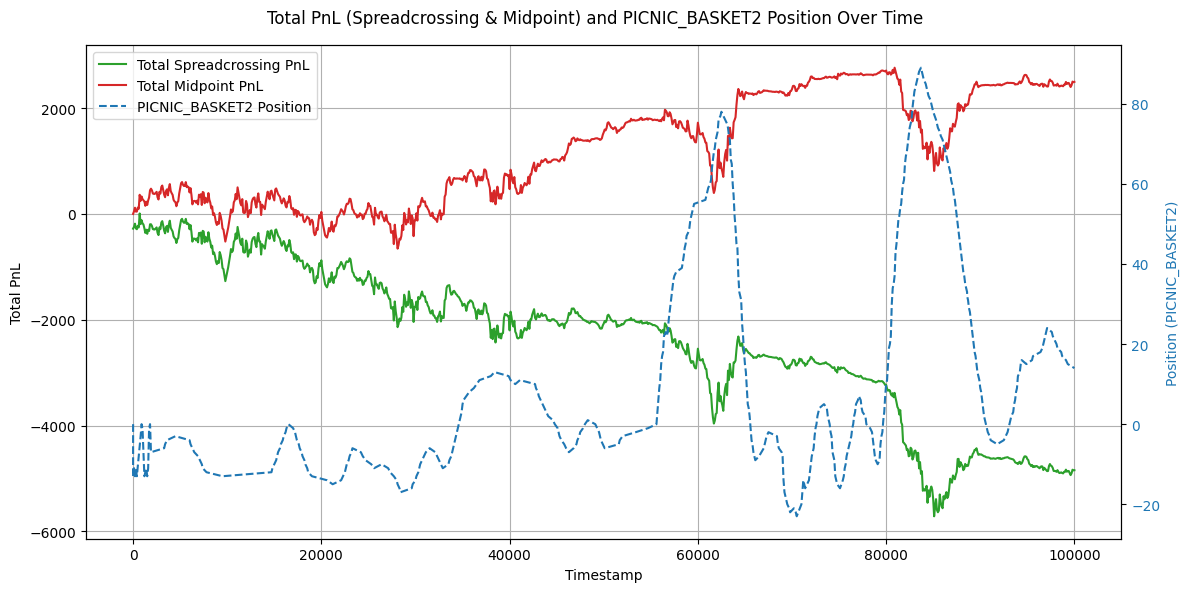

In [456]:
# 1. Calculate metrics for each symbol
metrics = {symbol: bt.calculate_metrics(symbol) for symbol in listings.keys()}

# 2. Compute total PnL over time for both strategies

# For Spreadcrossing PnL: Stack and sum over symbols
spread_pnl_matrix = np.array([metrics[sym]["spreadcrossing_pnl"] for sym in metrics])
total_spread_pnl_over_time = np.sum(spread_pnl_matrix, axis=0)

# For Midpoint PnL: Stack and sum over symbols
midpoint_pnl_matrix = np.array([metrics[sym]["midpoint_pnl"] for sym in metrics])
total_midpoint_pnl_over_time = np.sum(midpoint_pnl_matrix, axis=0)

# 3. Get the timestamps array (assuming all symbols share the same timestamps)
timestamps = metrics[next(iter(metrics))]["timestamp"]

# 4. Get position over time for a specific symbol (e.g., PICNIC_BASKET2)
etflog = Log.from_file('etfs.log')
picnic_timestamps, picnic_position = _calculate_position_over_time(PICNIC_BASKET2, etflog.trade_history, etflog.activities_log)

# 5. Plot total Spreadcrossing PnL and Midpoint PnL, and overlay PICNIC_BASKET2 position

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: Total PnL for both strategies
ax1.plot(timestamps, total_spread_pnl_over_time, color='tab:green', label="Total Spreadcrossing PnL")
ax1.plot(timestamps, total_midpoint_pnl_over_time, color='tab:red', label="Total Midpoint PnL")
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Total PnL", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Right y-axis: Position for PICNIC_BASKET2
ax2 = ax1.twinx()
ax2.plot(picnic_timestamps, picnic_position, color='tab:blue', linestyle='--', label="PICNIC_BASKET2 Position")
ax2.set_ylabel("Position (PICNIC_BASKET2)", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combine legends from both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Title and adjust layout
fig.suptitle("Total PnL (Spreadcrossing & Midpoint) and PICNIC_BASKET2 Position Over Time")
fig.tight_layout()
plt.show()


Are we being imbalanced? Lets see.

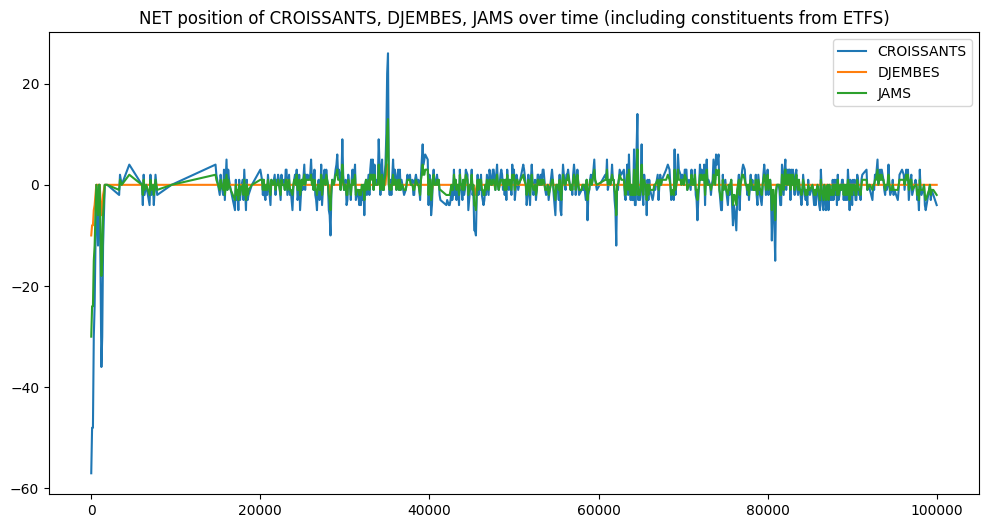

In [457]:
etflog = Log.from_file("etfs.log")

trade_history = etflog.trade_history


# map<timestamp, array<c,d,j>>
position_over_time = {}
count = [0, 0, 0]

for trade in trade_history:
    if trade.buyer != "SUBMISSION" and trade.seller != "SUBMISSION":
        continue

    sign = 1 if trade.buyer == "SUBMISSION" else -1

    if trade.symbol == CROISSANTS:
        count[0] += sign * abs(trade.quantity)
    elif trade.symbol == DJEMBES:
        count[1] += sign * abs(trade.quantity)
    elif trade.symbol == JAMS:
        count[2] += sign * abs(trade.quantity)
    elif trade.symbol == PICNIC_BASKET1:
        count[0] += sign * abs(6 * trade.quantity)
        count[1] += sign * abs(1 * trade.quantity)
        count[2] += sign * abs(3 * trade.quantity)
    elif trade.symbol == PICNIC_BASKET2:
        count[0] += sign * abs(4 * trade.quantity)
        count[2] += sign * abs(2 * trade.quantity)

    position_over_time[trade.timestamp] = count.copy()


timestamp = []
c = []
d = []
j = []

for ts, cdj in sorted(position_over_time.items()):
    timestamp.append(ts)
    c.append(cdj[0])
    d.append(cdj[1])
    j.append(cdj[2])

len(timestamp), len(c), len(d)

plt.figure(figsize=(12,6))

plt.plot(timestamp, c, label=CROISSANTS)
plt.plot(timestamp, d, label=DJEMBES)
plt.plot(timestamp, j, label=JAMS)
plt.legend()
plt.title("NET position of CROISSANTS, DJEMBES, JAMS over time (including constituents from ETFS)")
plt.show()

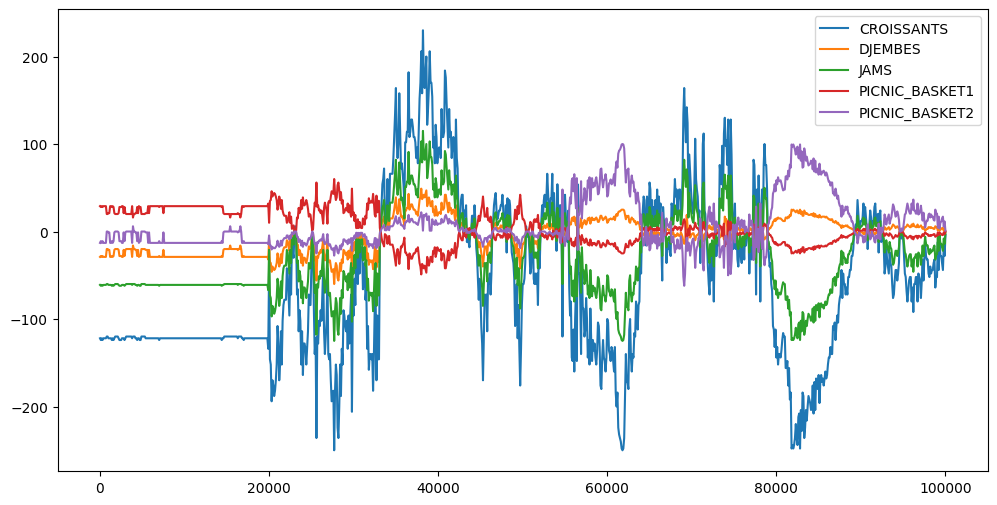

In [458]:
symbols = [CROISSANTS, DJEMBES, JAMS, PICNIC_BASKET1, PICNIC_BASKET2]

timestamps = bt.trader.desired_position_over_time['timestamp']
desired_pos_over_time = bt.trader.desired_position_over_time

 

plt.figure(figsize=(12,6))
for symbol in symbols:
    plt.plot(timestamps, desired_pos_over_time[symbol], label=symbol)
 
plt.legend()
plt.show()

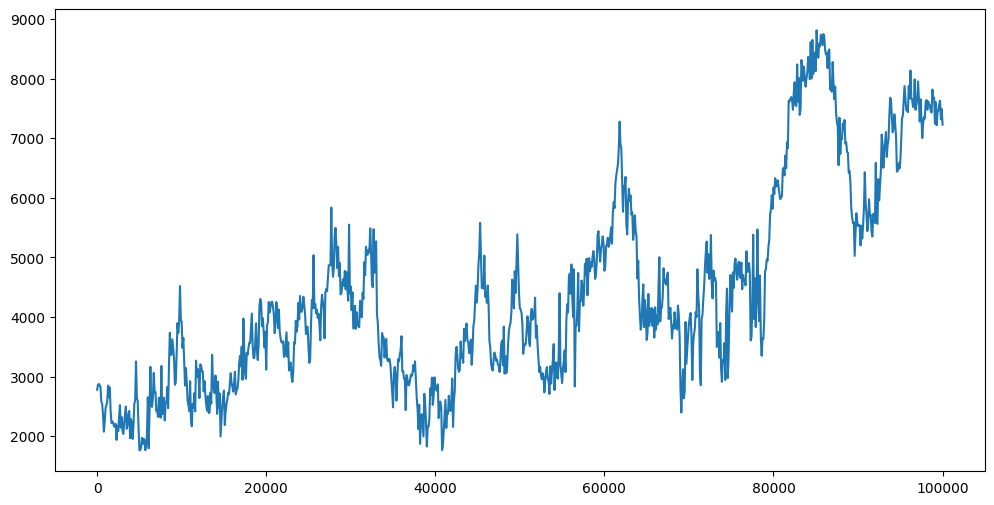

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(np.unique(md['timestamp']), bt.trader.max_profits_overimport pandas as pd
import matplotlib.pyplot as plt
import numpy as np

profits = pd.Series(bt.trader.max_profits_over_time)
timestamps = np.unique(md["timestamp"])
window = 1000  # you can change this to suit your needs

# Compute rolling z-score
rolling_mean = profits.rolling(window).mean()
rolling_std = profits.rolling(window).std()
z_score = (profits - rolling_mean) / rolling_std

# Plot profits and z-score
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: profits
ax1.plot(timestamps, profits, label="Profits", color='tab:blue')
ax1.set_ylabel("Profits", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis: z-score
ax2 = ax1.twinx()
ax2.plot(timestamps, z_score, label="Z-score", color='tab:red', alpha=0.6)
ax2.set_ylabel("Z-score", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Profits and Rolling Z-Score Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

profits = pd.Series(bt.trader.max_profits_over_time)
timestamps = np.unique(md["timestamp"])
window = 1000  # you can change this to suit your needs

# Compute rolling z-score
rolling_mean = profits.rolling(window).mean()
rolling_std = profits.rolling(window).std()
z_score = (profits - rolling_mean) / rolling_std

# Plot profits and z-score
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis: profits
ax1.plot(timestamps, profits, label="Profits", color='tab:blue')
ax1.set_ylabel("Profits", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis: z-score
ax2 = ax1.twinx()
ax2.plot(timestamps, z_score, label="Z-score", color='tab:red', alpha=0.6)
ax2.set_ylabel("Z-score", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Profits and Rolling Z-Score Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()
_time)
plt.show()

## Issues currently

- oscillating too much. e.g. the algo will buy 20 croissants just for it to want to sell them a tick later and buy it back again. this causes us to just pay a fuck ton of spread.  

- imbalance. the algo doesn't maintain hedging. If some orders don't get filled, those won't get adjusted in the future. we will just always stay unbalanced. Need some sort of regularisation to ensure that we maintain somewhat hedged.  

- sizing scheme. haven't implemented a sizing scheme yet lol.